# Separazione di immagini Cifar10

Il modello prende in input una immagine ottenuta come media di due campioni random presi da Cifar10, e deve predirre le categorie delle due componenti.

La prima immagine appartiene alle prime 5 categorie (airplane, automobile, bird, cat, deer), mentre la seconda appartiene alle restanti (dog, frog, horse, ship, truck). Il modello deve restituire due label, ognuna in un range di 5 valori.

La metrica con cui valutare il modello è la seguente: calcolate l'accuratezza della classificazione per le due immagini componenti, e poi fatene la media.

La metrica deve essere valutata su 10000 input generati da dati di test. Ripetete il calcolo 10 volte e misurate la deviazione standard, che deve essere riportata.

Nel seguito si fornisce un generatore dei dati e qualche esempio.

## Definizione delle costanti utilizzate

In [6]:
INPUT_SHAPE = (32,32,3)
KERNEL_SIZE = (3,3)
ACTIVATION = 'relu' #gelu, silu
BATCH_SIZE = 64
EPOCHS = 100
STEPS = 1100
DECAY_STEPS = int(0.1 * STEPS * EPOCHS)
DECAY_RATE = 0.9
POOL_SIZE = (2,2)
LEARNING_RATE = 0.005

#Preparazione dei dati

In [7]:
import tensorflow as tf
from keras.models import Model
from keras.datasets import cifar10
import numpy as np
from matplotlib import pyplot as plt


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step


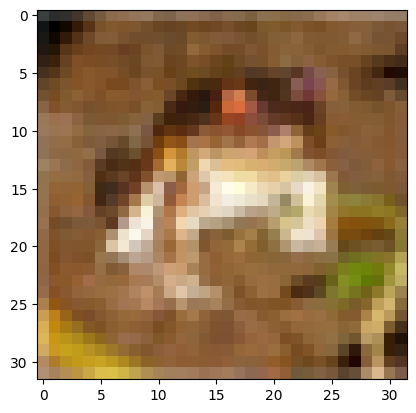

In [8]:
(cifar10_x_train, cifar10_y_train), (cifar10_x_test, cifar10_y_test) = cifar10.load_data()
assert cifar10_x_train.shape == (50000, 32, 32, 3)
assert cifar10_x_test.shape == (10000, 32, 32, 3)
assert cifar10_y_train.shape == (50000, 1)
assert cifar10_y_test.shape == (10000, 1)

classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
plt.imshow(cifar10_x_train[0])
cifar10_x_train = (cifar10_x_train/255.).astype(np.float32)
cifar10_x_test = (cifar10_x_test/255.).astype(np.float32)

Separiamo le immagini in due gruppi, in relazione alla loro etichetta.


In [10]:
cond_1 = cifar10_y_train[:,0] < 5
cifar10_x_train_1 = cifar10_x_train[cond_1]
cifar10_y_train_1 = cifar10_y_train[cond_1]

cond_2 = cifar10_y_train[:,0] >= 5
cifar10_x_train_2 = cifar10_x_train[cond_2]
cifar10_y_train_2 = cifar10_y_train[cond_2]

cond_1_test = cifar10_y_test[:,0] < 5
cifar10_x_test_1 = cifar10_x_test[cond_1_test]
cifar10_y_test_1 = cifar10_y_test[cond_1_test]

cond_2_test = cifar10_y_test[:,0] >= 5
cifar10_x_test_2 = cifar10_x_test[cond_2_test]
cifar10_y_test_2 = cifar10_y_test[cond_2_test]

Adesso possiamo definire il generatore. In input abbiamo due datasets (X1,X2), le etichette corrispondenti (Y1,Y2) e una batchsize.

Il generatore resituisce x_data, y_data, dove

*   x_data è una batch di immagini ottenute come media di campioni random in X1 and X2
*   y_data è una coppia di batch di etichette relative alle immagini componenti, espresse in formato categorico

In [11]:
def datagenerator(X1,X2,Y1,Y2,batchsize):
  size1 = X1.shape[0]
  size2 = X2.shape[0]
  Y1_cat = tf.keras.utils.to_categorical(Y1, num_classes=5)
  Y2_cat = tf.keras.utils.to_categorical(Y2-5, num_classes=5)

  while True:
    num1 = np.random.randint(0, size1, batchsize)
    num2 = np.random.randint(0, size2, batchsize)
    x_data = (X1[num1] + X2[num2]) / 2.0
    y_data = (Y1_cat[num1],Y2_cat[num2])

    yield x_data, y_data


In [19]:
#model architecture
from keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization

def convolutional_block(filters, input):
  x = Conv2D(filters, kernel_size=KERNEL_SIZE, activation=ACTIVATION, padding="same", data_format="channels_last")(input)
  x = BatchNormalization()(x)
  x = Conv2D(filters, kernel_size=KERNEL_SIZE, activation=ACTIVATION, padding="same", data_format="channels_last")(x)
  x = BatchNormalization()(x)
  x = Conv2D(filters, kernel_size=KERNEL_SIZE, activation=ACTIVATION, padding="same", data_format="channels_last")(x)
  x = BatchNormalization()(x)
  x = MaxPooling2D(pool_size=POOL_SIZE, padding="same", data_format="channels_last")(x)
  x = Dropout(0.2)(x)
  return x

def dense_block(input):
  x = Dense(128, activation=ACTIVATION)(input)
  x = Dropout(0.2)(x)
  x = Dense(24, activation=ACTIVATION)(x)
  x = Dropout(0.2)(x)
  return x

def model():
  #input layer
  input = Input(shape=INPUT_SHAPE, dtype="float32")
  #first convolutional block
  x = convolutional_block(16, input)
  #second convolutional block
  x = convolutional_block(32, x)
  #third convolutional block
  x = convolutional_block(64, x)
  #fourth convolutional block
  x = convolutional_block(128, x)
  #flattening
  x = Flatten()(x)
  #parallel dense layers
  x1 = dense_block(x)
  x2 = dense_block(x)
  #output layer
  output1 = Dense(5, activation="softmax", name="output_1")(x1)
  output2 = Dense(5, activation="softmax", name="output_2")(x2)
  return Model(input, [output1, output2])


In [20]:
import keras
from keras.optimizers.schedules import ExponentialDecay

lr_schedule = ExponentialDecay(
    initial_learning_rate=LEARNING_RATE,
    decay_steps=DECAY_STEPS,
    decay_rate=DECAY_RATE
)

optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)
model = model()


model.compile(
    optimizer=optimizer,
    loss={'output_1': 'categorical_crossentropy', 'output_2': 'categorical_crossentropy'},
    metrics={'output_1': 'accuracy', 'output_2': 'accuracy'}
  )
model.summary()



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_12 (Conv2D)        │ (None, 32, 32, 16)     │            448 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_12    │ (None, 32, 32, 16)     │             64 │ conv2d_12[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_13 (Conv2D)        │ (None, 32, 32, 16)     │          2,320 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_13    │ (None, 32, 32, 16)     │             64 │ conv2d_13[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_14 (Conv2D)        │ (None, 32, 32, 16)     │          2,320 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_14    │ (None, 32, 32, 16)     │             64 │ conv2d_14[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 16, 16, 16)     │              0 │ batch_normalization_1… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_8 (Dropout)       │ (None, 16, 16, 16)     │              0 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_15 (Conv2D)        │ (None, 16, 16, 32)     │          4,640 │ dropout_8[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_15    │ (None, 16, 16, 32)     │            128 │ conv2d_15[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_16 (Conv2D)        │ (None, 16, 16, 32)     │          9,248 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_16    │ (None, 16, 16, 32)     │            128 │ conv2d_16[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_17 (Conv2D)        │ (None, 16, 16, 32)     │          9,248 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_17    │ (None, 16, 16, 32)     │            128 │ conv2d_17[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5      

 Total params: 630,250 (2.40 MB)

 Trainable params: 628,810 (2.40 MB)

 Non-trainable params: 1,440 (5.62 KB)

Instanziamo un generatore su Cifar10 con batchsize=1, e testiamone il comportamento.

In [21]:
datagen = datagenerator(cifar10_x_train_1,cifar10_x_train_2,cifar10_y_train_1,cifar10_y_train_2, BATCH_SIZE)
validationgen = datagenerator(cifar10_x_test_1,cifar10_x_test_2,cifar10_y_test_1,cifar10_y_test_2, 10000)

x, y = next(validationgen)
test_inputs = x
test_labels1 = y[0]
test_labels2 = y[1]

history = model.fit(
    x=datagen,
    validation_data=(test_inputs, {'output_1': test_labels1, 'output_2': test_labels2}),  # Validation data
    steps_per_epoch=STEPS,  # Number of batches per epoch
    epochs=EPOCHS  # Number of epochs
)



Epoch 1/100
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 39s 16ms/step - loss: 3.2126 - output_1_accuracy: 0.2353 - output_1_loss: 1.6151 - output_2_accuracy: 0.2417 - output_2_loss: 1.5975 - val_loss: 3.1324 - val_output_1_accuracy: 0.2060 - val_output_1_loss: 1.6382 - val_output_2_accuracy: 0.2949 - val_output_2_loss: 1.4943
Epoch 2/100
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - loss: 3.0021 - output_1_accuracy: 0.2898 - output_1_loss: 1.5149 - output_2_accuracy: 0.3095 - output_2_loss: 1.4872 - val_loss: 2.8971 - val_output_1_accuracy: 0.3112 - val_output_1_loss: 1.4800 - val_output_2_accuracy: 0.3544 - val_output_2_loss: 1.4174
Epoch 3/100
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - loss: 2.9036 - output_1_accuracy: 0.3407 - output_1_loss: 1.4485 - output_2_accuracy: 0.3240 - output_2_loss: 1.4551 - val_loss: 2.9277 - val_output_1_accuracy: 0.3358 - val_output_1_loss: 1.5263 - val_output_2_accuracy: 0.3798 - val_output_2_loss: 1.4018
Epoch 4/100
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/ste

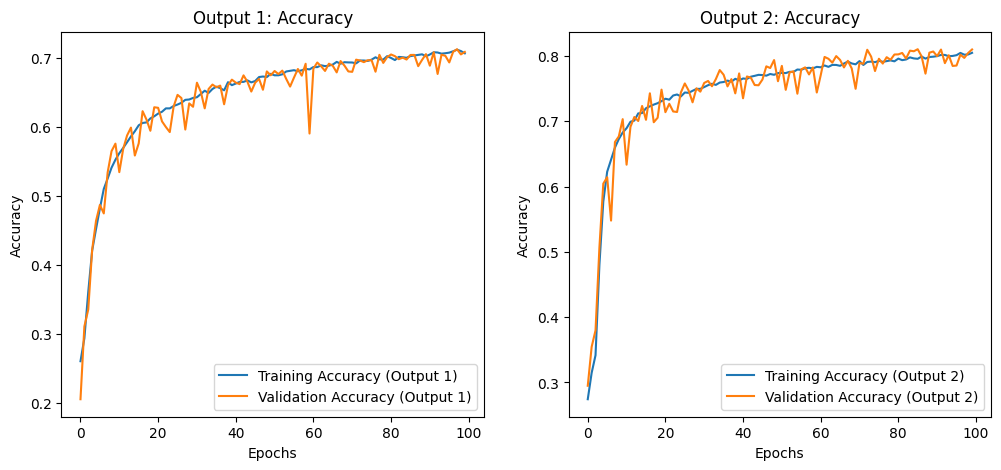

In [22]:
# Access the history data
history_dict = history.history

# Plot training and validation accuracy for each output
plt.figure(figsize=(12, 5))

# Plot accuracy for output1
plt.subplot(1, 2, 1)
plt.plot(history_dict['output_1_accuracy'], label='Training Accuracy (Output 1)')
plt.plot(history_dict['val_output_1_accuracy'], label='Validation Accuracy (Output 1)')
plt.title('Output 1: Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot accuracy for output2
plt.subplot(1, 2, 2)
plt.plot(history_dict['output_2_accuracy'], label='Training Accuracy (Output 2)')
plt.plot(history_dict['val_output_2_accuracy'], label='Validation Accuracy (Output 2)')
plt.title('Output 2: Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [23]:
model.save_weights("model.weights.h5")
#model.load_weights("model.weights.h5")

Generiamo un esempio, mostriamo l'immagine che deve essere presa in input dal modello, e stampiamo le categorie delle due componenti sovrapposte.

Potete rirpetere l'esecuzione della cella per mostrare nuovi esempi.

first: airplane, second = dog


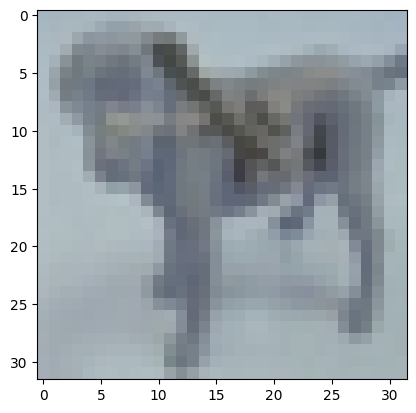

In [24]:
x, y = next(datagen)

print("first: {}, second = {}".format(classes[np.argmax(y[0][0])],classes[np.argmax(y[1][0])+5]))
#print(np.min(x[0]),np.max(x[0]))
plt.imshow(x[0])

# Valutazione

Dfiniamo innanzi tutto il generatore di testing.

In [28]:
testgen = datagenerator(cifar10_x_test_1,cifar10_x_test_2,cifar10_y_test_1,cifar10_y_test_2,10000)

eval_samples_x, eval_samples_y = next(testgen)
print(eval_samples_x.shape)

(10000, 32, 32, 3)


Testiamo con una nodello che produce predizioni random. Voi dovrete sostituire questo modello con il vostro modello predittivo.

In [25]:
def random_model(x):
  #the random model ingnore the input x and return a pair of random classes
  return(np.random.randint(0,5,(10000,2)))

In [32]:


def eval_model(model):
  eval_samples_x, eval_samples_y = next(testgen)
  model_output = model.predict(eval_samples_x)
  model_output = np.array(model_output)
  eval_samples_y = np.array(eval_samples_y)
  print(np.array(model_output).shape)
  print(np.array(eval_samples_y).shape)

  correct_guesses_1 = np.argmax(model_output[0],axis=1) == np.argmax(eval_samples_y[0],axis=1)
  correct_guesses_2 = np.argmax(model_output[1],axis=1) == np.argmax(eval_samples_y[1],axis=1)
  return (np.mean(correct_guesses_1) + np.mean(correct_guesses_2))/2

In [33]:
eval_model(model)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
(2, 10000, 5)
(2, 10000, 5)


0.75875

let us repeat the evaluation ten times, and comput the standard deviation

In [34]:
repeat_eval = 10
eval_results = []
for i in range(repeat_eval):
  eval_results.append(eval_model(model))
print("mean accuracy = ", np.mean(eval_results))
print("standard deviation = ", np.std(eval_results))

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
(2, 10000, 5)
(2, 10000, 5)
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(2, 10000, 5)
(2, 10000, 5)
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(2, 10000, 5)
(2, 10000, 5)
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
(2, 10000, 5)
(2, 10000, 5)
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(2, 10000, 5)
(2, 10000, 5)
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(2, 10000, 5)
(2, 10000, 5)
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(2, 10000, 5)
(2, 10000, 5)
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(2, 10000, 5)
(2, 10000, 5)
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(2, 10000, 5)
(2, 10000, 5)
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(2, 10000, 5)
(2, 10000, 5)
mean accuracy =  0.755745
standard deviation =  0.002714263251786771


# Cosa consegnare

Come di consueto, dovete consegnare un singolo notebook che deve essere eseguibile su colab. Il notebook deve essere adeguatamente commentato a contenere una traccia completa del training, come anche il calcolo della accuratezza secondo le direttive date sopra.

#Buon lavoro!